# Dev-Jor

Dataset: MS COCO (lest your GPU has constraints then use Flickr8k/30k let us know)

Evaluation: BLEU, METEOR, and CIDEr
1. Pretrained CNN + Untrained RNN

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import nltk
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
# from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
# from nltk.translate.meteor_score import meteor_score
# from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            ann_file (string): Path to annotation file
            transform: Transform pipeline for images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load and transform image
        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id

# Define the transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for random cropping
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
])

# Simpler transform pipeline for validation/testing
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No random cropping during validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [3]:
# Define base paths
BASE_PATH = 'data'
IMG_DIR = os.path.join(BASE_PATH, 'images')
ANN_DIR = os.path.join(BASE_PATH, 'annotations/trainval2017')

In [4]:
# Create datasets
train_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'train2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_train2017.json'),
    transform=train_transform,
) 

val_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=val_transform,
)


# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, num_workers=0)
print(len(train_loader), len(val_loader))
print(len(train_loader.dataset), len(val_loader.dataset))

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
18493 782
591753 25014


In [5]:
# Create a dataloader itterable object
dataiter = next(iter(val_loader))
# Sample from the itterable object
test_images, test_captions, test_img_ids = dataiter

A smiling man is wearing a hot pink tie.
('A smiling man is wearing a hot pink tie.', 'a zebra grazes on some green grass next to some trees ', 'A man with an umbrella is smiling on a cloudy day.', 'A man preparing food on a large old oven.', 'A boy is riding a skateboard past many food carts.', 'Two women ride horses in the water at the beach.', 'A cat sits on the edge of a toilet.', 'Two giraffe standing on a field together grazing on green grass.', 'A river is seen from afar and the river is next to a city that features old buildings.', 'there is a yellow and red train at a train stop', 'A grand piano in a formal residential living room', 'A person that is snowboarding in some snow.', 'The clock tower is on the first floor of the tall building. ', 'a man is holding some stuff standing by the curb', 'A boy is hitting a tennis ball on a tennis court. ', 'There is a small bathroom with a white vanity.', 'Two rusty parking meters are displayed with graffiti in the background.', 'A tenni

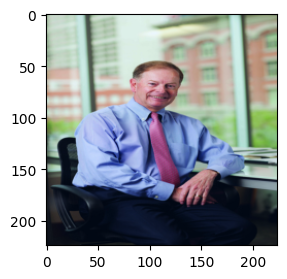

In [6]:
# Lets visualise an entire batch of images
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)
print(test_captions)

In [7]:
# Initialize tokenizer once
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print(tokenizer.vocab_size)

# Let's test with one caption
sample_caption = test_captions[0]
print("\nSample caption:", sample_caption)
# Ensure  `test_captions` is a list of strings
test_captions_list = [caption for caption in test_captions]

30522

Sample caption: A smiling man is wearing a hot pink tie.


c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
tokens = tokenizer(test_captions_list, padding=True, truncation=True, return_tensors="pt")

# Batch size x sequence length
print(tokens['input_ids'])
print(len(tokens['input_ids']))

# Sequence length
print(tokens['input_ids'][0])
print(len(tokens['input_ids'][0]))

# print the length of all the captions in a batch
for i in range(len(tokens['input_ids'])):
    print(len(tokens['input_ids'][i]), end=', ')

tensor([[  101,  1037,  5629,  2158,  2003,  4147,  1037,  2980,  5061,  5495,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037, 29145, 26918,  2229,  2006,  2070,  2665,  5568,  2279,
          2000,  2070,  3628,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2158,  2007,  2019, 12977,  2003,  5629,  2006,  1037,
         24706,  2154,  1012,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2158,  8225,  2833,  2006,  1037,  2312,  2214, 17428,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2879,  2003,  5559,  1037, 17260,  6277,  2627,  2116,
          2833, 25568,  1012,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  2048,  2308,  4536,  5194,  1999,  1996,  2300,  2012,  1996,
          3509,  1012,   102,     0,     0,   

In [9]:
print(tokenizer.decode(tokens['input_ids'][0]))

[CLS] a smiling man is wearing a hot pink tie. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Displaying 3 random samples from the dataset...

Sample 1:
--------------------------------------------------------------------------------


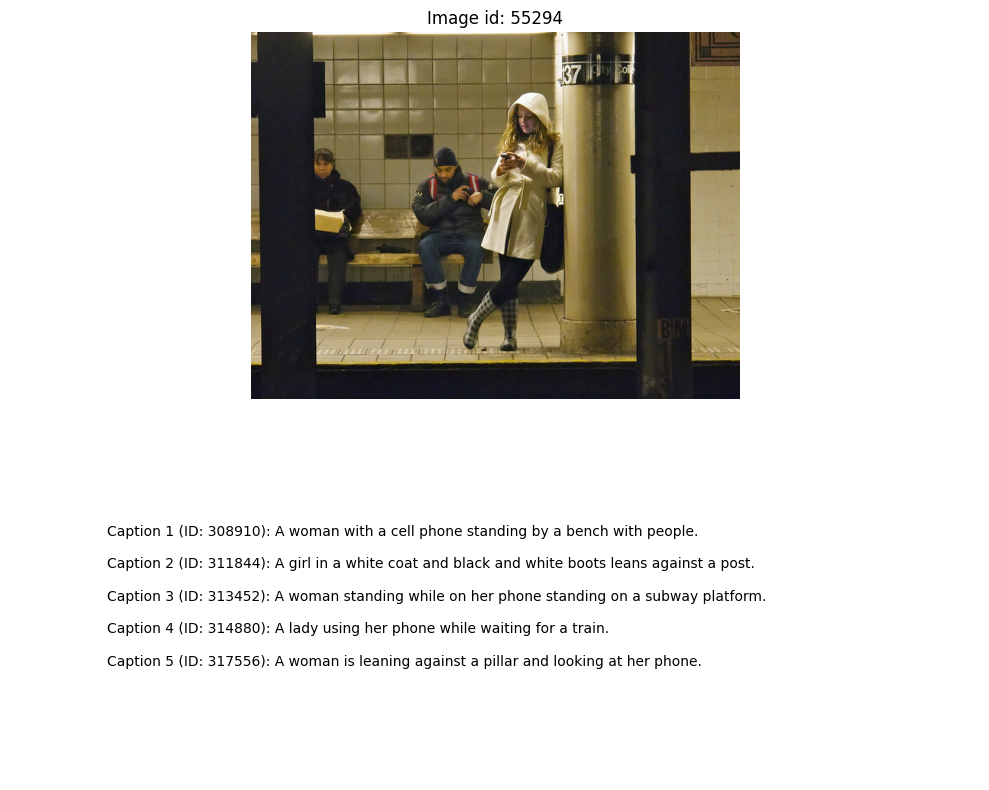


Sample 2:
--------------------------------------------------------------------------------


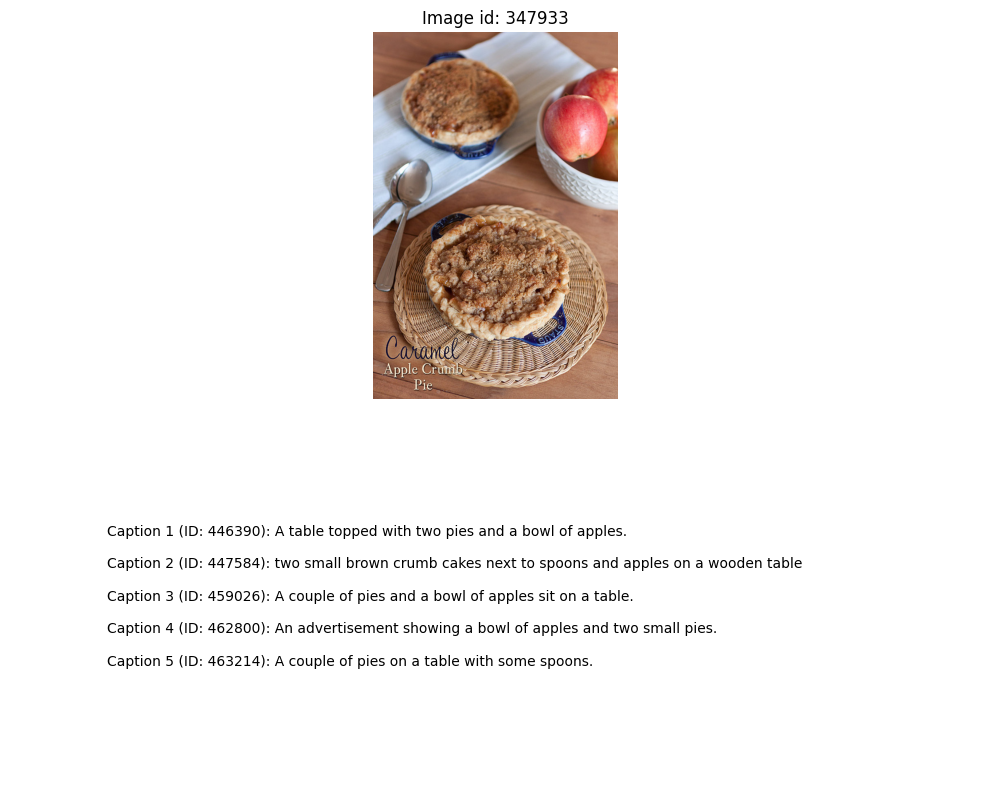


Sample 3:
--------------------------------------------------------------------------------


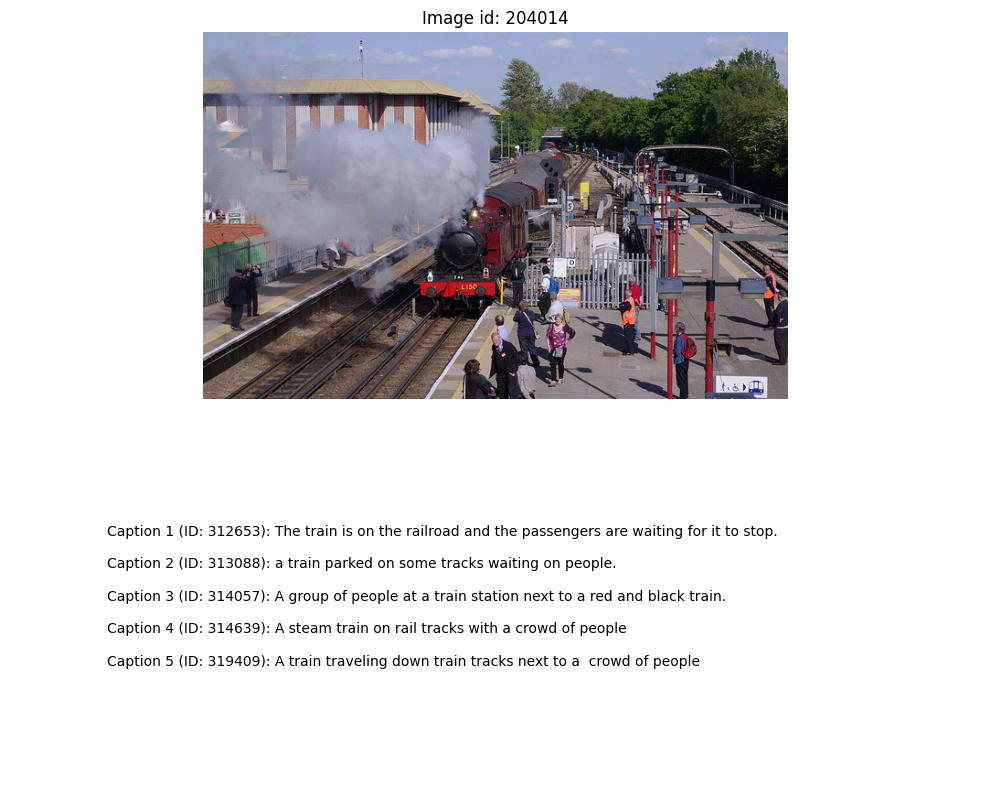

In [10]:
def display_dataset_samples(dataset, num_samples=3):
    """
    Display multiple random samples from the dataset with their captions.

    Args:
        dataset: CocoDataset instance
        num_samples: Number of samples to display
    """
    coco_caps = dataset.coco
    root_dir = dataset.root_dir

    print(f"Displaying {num_samples} random samples from the dataset...")

    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        print("-" * 80)

        # Get a random image ID
        img_ids = coco_caps.getImgIds()
        img_id = random.choice(img_ids)

        # Load image info
        img_info = coco_caps.loadImgs([img_id])[0]

        # Load image using PIL
        img_path = os.path.join(root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get and display captions
        ann_ids = coco_caps.getAnnIds(imgIds=img_id)
        anns = coco_caps.loadAnns(ann_ids)

        # Create text display for captions
        caption_text = '\n\n'.join([f"Caption {i+1} (ID: {ann['id']}): {ann['caption']}"
                                   for i, ann in enumerate(anns)])

        # Display image and captions
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Image id: ' + str(img_id))
        ax2.text(0.1, 0.5, caption_text,
                 wrap=True,
                 verticalalignment='center',
                 fontsize=10)
        ax2.axis('off')
        plt.tight_layout()
        plt.show()

# Display some samples from the training dataset
display_dataset_samples(train_dataset, num_samples=3)

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size=512):
        super(EncoderCNN, self).__init__()
        
        # Load pretrained ResNet50
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Remove the last FC layer and pool5
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Add a pointwise convolution to reduce the number of channels
        # Also preserve spatial information
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        # Freeze ResNet50 parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, width, height = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features
        

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize states from features
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def init_hidden_states(self, features):
        # Average the spatial features
        avg_features = features.mean(dim=1)  # [batch_size, hidden_size]
        
        # Initialize hidden and cell states
        h = self.init_h(avg_features).unsqueeze(0)  # [1, batch_size, hidden_size]
        c = self.init_c(avg_features).unsqueeze(0)
        return h, c

    def forward(self, features, captions):
        """
        features: [batch_size, num_pixels, hidden_size]
        captions: [batch_size, seq_length]
        """
        # Embed captions
        embeddings = self.dropout(self.embed(captions))  # [batch_size, seq_length, embed_size]
        
        # Initialize hidden states
        hidden = self.init_hidden_states(features)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(embeddings, hidden)
        outputs = self.linear(lstm_out)  # [batch_size, seq_length, vocab_size]
        
        return outputs
    
    def sample(self, features, tokenizer, max_len=20):
        """Generate caption using greedy search"""
        self.eval()
        batch_size = features.size(0)
        
        # Initialize hidden states
        hidden = self.init_hidden_states(features)
        
        # Start with CLS token
        inputs = torch.tensor([tokenizer.cls_token_id]).repeat(batch_size, 1).to(features.device)
        
        captions = []
        for i in range(max_len):
            # Forward pass through decoder
            embeddings = self.embed(inputs)
            lstm_out, hidden = self.lstm(embeddings, hidden)
            outputs = self.linear(lstm_out[:, -1])
            
            # Sample the next word
            predicted = outputs.argmax(dim=1)
            captions.append(predicted)
            
            # Break if SEP token is predicted
            if predicted.item() == tokenizer.sep_token_id:
                break
                
            inputs = predicted.unsqueeze(1)
        
        return torch.stack(captions, 1)

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(hidden_size)
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, tokenizer, max_len=20):
        features = self.encoder(image)
        caption_ids = self.decoder.sample(features, tokenizer, max_len)
        
        # Decode the caption
        caption = tokenizer.decode(caption_ids[0]) #, skip_special_tokens=True
        return caption

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.min_val_loss:
                self.min_val_loss = val_loss
            self.best_loss = val_loss
            self.counter = 0

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, tokenizer,
                 num_epochs=30, device='cuda'):
    # Create checkpoint directory
    current_dir = os.getcwd()
    save_dir = os.path.join(current_dir, 'data/fifth model checkpoints')
    os.makedirs(save_dir, exist_ok=True)

    # Initialize training tracking
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Path for best model
    best_model_path = os.path.join(save_dir, 'best_model.pt')

    # Initialize early stopping
    # early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training loop
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_steps = 0

        train_progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for images, captions, _ in train_progress_bar:
            images = images.to(device)

            # Tokenize captions
            captions_list = [caption for caption in captions]  # Convert tuple to list
            tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            
            # Teacher forcing 
            # https://www.margotwagner.com/project/image-captioning-using-an-lstm-network/image-captioning-using-an-lstm-network.pdf
            inputs = token_ids[:, :-1]
            targets = token_ids[:, 1:]

            # Forward pass
            outputs = model(images, inputs)

            # Reshape outputs and targets for loss calculation
            batch_size, seq_length, vocab_size = outputs.shape
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Calculate accuracy (excluding padding tokens)
            mask = targets != tokenizer.pad_token_id
            predictions = outputs.argmax(dim=1)
            correct = ((predictions == targets) * mask).sum().item()
            total = mask.sum().item()
            accuracy = correct / total if total > 0 else 0

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update training metrics
            train_loss += loss.item()
            train_accuracy += accuracy
            train_steps += 1

            train_progress_bar.set_postfix({'train_loss': train_loss / train_steps, 'train_accuracy': train_accuracy / train_steps})
        
        avg_train_loss = train_loss / train_steps
        avg_train_accuracy = train_accuracy / train_steps
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_steps = 0

        val_progress_bar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for images, captions, _ in val_progress_bar:
                images = images.to(device)

                 # Tokenize captions
                captions_list = [caption for caption in captions]
                tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
                token_ids = tokens['input_ids'].to(device)

                inputs = token_ids[:, :-1]
                targets = token_ids[:, 1:]
                
                outputs = model(images, inputs)

                # Reshape for loss calculation
                batch_size, seq_length, vocab_size = outputs.shape
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)
                
                loss = criterion(outputs, targets)

                # Calculate accuracy
                mask = targets != tokenizer.pad_token_id
                predictions = outputs.argmax(dim=1)
                correct = ((predictions == targets) * mask).sum().item()
                total = mask.sum().item()
                accuracy = correct / total if total > 0 else 0

                # Update validation metrics
                val_loss += loss.item()
                val_accuracy += accuracy
                val_steps += 1

                val_progress_bar.set_postfix({'val_loss': val_loss / val_steps, 'val_accuracy': val_accuracy / val_steps})
        
        avg_val_loss = val_loss / val_steps
        avg_val_accuracy = val_accuracy / val_steps
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Early stopping check
        # early_stopping(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_accuracy,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_accuracy,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }, best_model_path)
            print(f"New best model saved to {best_model_path}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_accuracy,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_accuracy,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f'Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Train Accuracy: {avg_train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {avg_val_accuracy:.4f}')
        print('-' * 60)

        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
# Model hyperparameters
embed_size = 512
hidden_size = 512
vocab_size = tokenizer.vocab_size
learning_rate = 1e-4

# Create model instance
model = ImageCaptioningModel(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = criterion,
    optimizer = optimizer,
    tokenizer = tokenizer,
    num_epochs = 30,
    device = device
)

Epoch 1/30 [Validation]: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s, val_loss=2.62, val_accuracy=0.476]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 1/30
Time: 7176.10s
Train Loss: 3.1055
Train Accuracy: 0.4259
Val Loss: 2.6210
Val Accuracy: 0.4763
------------------------------------------------------------


Epoch 2/30 [Validation]: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s, val_loss=2.44, val_accuracy=0.497]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 2/30
Time: 7139.89s
Train Loss: 2.5437
Train Accuracy: 0.4806
Val Loss: 2.4410
Val Accuracy: 0.4967
------------------------------------------------------------


Epoch 3/30 [Validation]: 100%|██████████| 782/782 [04:01<00:00,  3.23it/s, val_loss=2.36, val_accuracy=0.506]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 3/30
Time: 7201.07s
Train Loss: 2.4075
Train Accuracy: 0.4951
Val Loss: 2.3626
Val Accuracy: 0.5059
------------------------------------------------------------


Epoch 4/30 [Validation]: 100%|██████████| 782/782 [03:25<00:00,  3.80it/s, val_loss=2.31, val_accuracy=0.512]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 4/30
Time: 7011.30s
Train Loss: 2.3305
Train Accuracy: 0.5033
Val Loss: 2.3135
Val Accuracy: 0.5116
------------------------------------------------------------


Epoch 5/30 [Validation]: 100%|██████████| 782/782 [03:32<00:00,  3.69it/s, val_loss=2.28, val_accuracy=0.515]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt
Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_5.pt

Epoch 5/30
Time: 7131.70s
Train Loss: 2.2776
Train Accuracy: 0.5089
Val Loss: 2.2844
Val Accuracy: 0.5147
------------------------------------------------------------


Epoch 6/30 [Validation]: 100%|██████████| 782/782 [03:32<00:00,  3.68it/s, val_loss=2.26, val_accuracy=0.518]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 6/30
Time: 7100.65s
Train Loss: 2.2385
Train Accuracy: 0.5133
Val Loss: 2.2629
Val Accuracy: 0.5183
------------------------------------------------------------


Epoch 7/30 [Validation]: 100%|██████████| 782/782 [03:31<00:00,  3.70it/s, val_loss=2.25, val_accuracy=0.52] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 7/30
Time: 6961.00s
Train Loss: 2.2071
Train Accuracy: 0.5166
Val Loss: 2.2456
Val Accuracy: 0.5204
------------------------------------------------------------


Epoch 8/30 [Validation]: 100%|██████████| 782/782 [03:30<00:00,  3.71it/s, val_loss=2.23, val_accuracy=0.522]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 8/30
Time: 7091.41s
Train Loss: 2.1814
Train Accuracy: 0.5195
Val Loss: 2.2346
Val Accuracy: 0.5219
------------------------------------------------------------


Epoch 9/30 [Validation]: 100%|██████████| 782/782 [03:28<00:00,  3.75it/s, val_loss=2.22, val_accuracy=0.523]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 9/30
Time: 6983.00s
Train Loss: 2.1597
Train Accuracy: 0.5218
Val Loss: 2.2237
Val Accuracy: 0.5234
------------------------------------------------------------


Epoch 10/30 [Validation]: 100%|██████████| 782/782 [04:21<00:00,  2.99it/s, val_loss=2.21, val_accuracy=0.524]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt
Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_10.pt

Epoch 10/30
Time: 7288.86s
Train Loss: 2.1409
Train Accuracy: 0.5240
Val Loss: 2.2134
Val Accuracy: 0.5245
------------------------------------------------------------


Epoch 11/30 [Validation]: 100%|██████████| 782/782 [04:02<00:00,  3.22it/s, val_loss=2.21, val_accuracy=0.525]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 11/30
Time: 7850.72s
Train Loss: 2.1241
Train Accuracy: 0.5257
Val Loss: 2.2078
Val Accuracy: 0.5253
------------------------------------------------------------


Epoch 12/30 [Validation]: 100%|██████████| 782/782 [04:11<00:00,  3.10it/s, val_loss=2.2, val_accuracy=0.527] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 12/30
Time: 7752.60s
Train Loss: 2.1094
Train Accuracy: 0.5272
Val Loss: 2.2024
Val Accuracy: 0.5268
------------------------------------------------------------


Epoch 13/30 [Validation]: 100%|██████████| 782/782 [03:55<00:00,  3.31it/s, val_loss=2.2, val_accuracy=0.527] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 13/30
Time: 7640.01s
Train Loss: 2.0963
Train Accuracy: 0.5287
Val Loss: 2.1959
Val Accuracy: 0.5272
------------------------------------------------------------


Epoch 14/30 [Validation]: 100%|██████████| 782/782 [03:59<00:00,  3.26it/s, val_loss=2.19, val_accuracy=0.528]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 14/30
Time: 7145.92s
Train Loss: 2.0839
Train Accuracy: 0.5301
Val Loss: 2.1944
Val Accuracy: 0.5278
------------------------------------------------------------


Epoch 15/30 [Validation]: 100%|██████████| 782/782 [03:41<00:00,  3.53it/s, val_loss=2.19, val_accuracy=0.528]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt
Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_15.pt

Epoch 15/30
Time: 6879.36s
Train Loss: 2.0731
Train Accuracy: 0.5314
Val Loss: 2.1914
Val Accuracy: 0.5284
------------------------------------------------------------


Epoch 16/30 [Validation]: 100%|██████████| 782/782 [03:47<00:00,  3.43it/s, val_loss=2.19, val_accuracy=0.529]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 16/30
Time: 7333.99s
Train Loss: 2.0631
Train Accuracy: 0.5324
Val Loss: 2.1896
Val Accuracy: 0.5292
------------------------------------------------------------


Epoch 17/30 [Validation]: 100%|██████████| 782/782 [03:26<00:00,  3.79it/s, val_loss=2.19, val_accuracy=0.53] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 17/30
Time: 6810.89s
Train Loss: 2.0540
Train Accuracy: 0.5333
Val Loss: 2.1855
Val Accuracy: 0.5297
------------------------------------------------------------


Epoch 18/30 [Validation]: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, val_loss=2.19, val_accuracy=0.529]



Epoch 18/30
Time: 6925.99s
Train Loss: 2.0450
Train Accuracy: 0.5344
Val Loss: 2.1870
Val Accuracy: 0.5292
------------------------------------------------------------


Epoch 19/30 [Validation]: 100%|██████████| 782/782 [03:30<00:00,  3.71it/s, val_loss=2.18, val_accuracy=0.53] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 19/30
Time: 6909.54s
Train Loss: 2.0368
Train Accuracy: 0.5353
Val Loss: 2.1831
Val Accuracy: 0.5300
------------------------------------------------------------


Epoch 20/30 [Validation]: 100%|██████████| 782/782 [03:30<00:00,  3.72it/s, val_loss=2.18, val_accuracy=0.53] 


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_20.pt

Epoch 20/30
Time: 6807.74s
Train Loss: 2.0292
Train Accuracy: 0.5362
Val Loss: 2.1833
Val Accuracy: 0.5302
------------------------------------------------------------


Epoch 21/30 [Validation]: 100%|██████████| 782/782 [04:09<00:00,  3.14it/s, val_loss=2.18, val_accuracy=0.53] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\best_model.pt

Epoch 21/30
Time: 7002.79s
Train Loss: 2.0218
Train Accuracy: 0.5369
Val Loss: 2.1829
Val Accuracy: 0.5304
------------------------------------------------------------


Epoch 22/30 [Validation]: 100%|██████████| 782/782 [03:51<00:00,  3.37it/s, val_loss=322, val_accuracy=0.497]   



Epoch 22/30
Time: 7234.09s
Train Loss: 485696540.2725
Train Accuracy: 0.5102
Val Loss: 322.2039
Val Accuracy: 0.4975
------------------------------------------------------------


Epoch 23/30 [Validation]: 100%|██████████| 782/782 [03:54<00:00,  3.33it/s, val_loss=10.2, val_accuracy=0.488]



Epoch 23/30
Time: 7024.03s
Train Loss: 743.1478
Train Accuracy: 0.4824
Val Loss: 10.1835
Val Accuracy: 0.4882
------------------------------------------------------------


Epoch 24/30 [Validation]: 100%|██████████| 782/782 [03:51<00:00,  3.38it/s, val_loss=2.55, val_accuracy=0.486]



Epoch 24/30
Time: 6982.18s
Train Loss: 4.0463
Train Accuracy: 0.4698
Val Loss: 2.5522
Val Accuracy: 0.4861
------------------------------------------------------------


Epoch 25/30 [Validation]: 100%|██████████| 782/782 [03:55<00:00,  3.33it/s, val_loss=2.39, val_accuracy=0.503]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_25.pt

Epoch 25/30
Time: 7081.21s
Train Loss: 9010363.5082
Train Accuracy: 0.4924
Val Loss: 2.3914
Val Accuracy: 0.5027
------------------------------------------------------------


Epoch 26/30 [Validation]: 100%|██████████| 782/782 [04:01<00:00,  3.24it/s, val_loss=2.39, val_accuracy=0.503]



Epoch 26/30
Time: 7247.16s
Train Loss: 24291565.8882
Train Accuracy: 0.4953
Val Loss: 2.3909
Val Accuracy: 0.5032
------------------------------------------------------------


Epoch 27/30 [Validation]: 100%|██████████| 782/782 [04:01<00:00,  3.24it/s, val_loss=2.4, val_accuracy=0.507] 



Epoch 27/30
Time: 7314.95s
Train Loss: 467063.9051
Train Accuracy: 0.4991
Val Loss: 2.4016
Val Accuracy: 0.5065
------------------------------------------------------------


Epoch 28/30 [Validation]: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s, val_loss=1.08e+7, val_accuracy=0.471]



Epoch 28/30
Time: 7083.14s
Train Loss: 371270352.3186
Train Accuracy: 0.4806
Val Loss: 10792447.4967
Val Accuracy: 0.4713
------------------------------------------------------------


Epoch 29/30 [Validation]: 100%|██████████| 782/782 [03:37<00:00,  3.60it/s, val_loss=13.7, val_accuracy=0.45] 



Epoch 29/30
Time: 7104.04s
Train Loss: 2461681.3485
Train Accuracy: 0.4517
Val Loss: 13.6595
Val Accuracy: 0.4502
------------------------------------------------------------


Epoch 30/30 [Validation]: 100%|██████████| 782/782 [03:34<00:00,  3.64it/s, val_loss=4.3, val_accuracy=0.459] 


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/fifth model checkpoints\checkpoint_30.pt

Epoch 30/30
Time: 6613.03s
Train Loss: 2666931.6115
Train Accuracy: 0.4386
Val Loss: 4.2984
Val Accuracy: 0.4593
------------------------------------------------------------


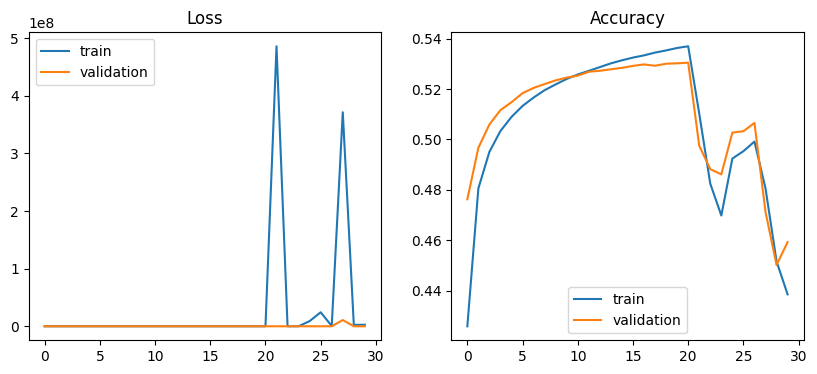

In [15]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

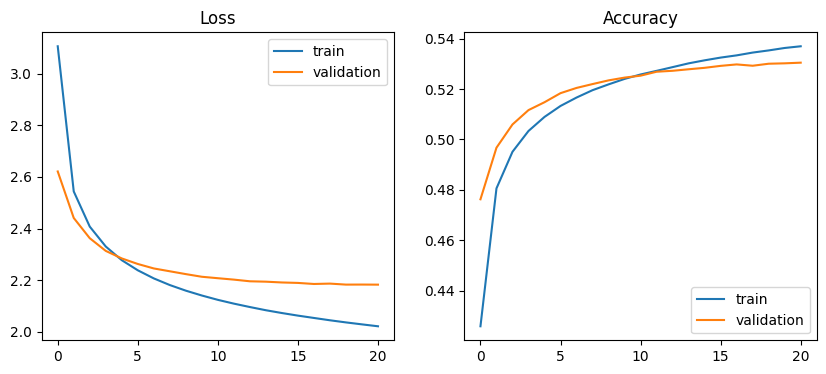

In [18]:
# Plot training and validation loss and accuracy up till epoch 21
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses[:21], label='train')
plt.plot(val_losses[:21], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies[:21], label='train')
plt.plot(val_accuracies[:21], label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

# Testing

In [11]:
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
# Dataset class modified to use BERT tokenizer
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id
    
# Load validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [14]:
# Set paths
BASE_DIR = 'data'
MODEL_NAME = 'best_model.pt'
CHECKPOINT_PATH = 'data/fifth model checkpoints/'
MODEL_PATH = os.path.join(CHECKPOINT_PATH, MODEL_NAME)
IMG_DIR = os.path.join(BASE_DIR, 'images')
ANN_DIR = os.path.join(BASE_DIR, 'annotations/trainval2017')

# Create validation dataset and loader
val_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=transform
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size=512):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, h, w = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        batch_size = features.size(0)
        h = self.init_h(features.mean(dim=1)).unsqueeze(0)
        c = self.init_c(features.mean(dim=1)).unsqueeze(0)
        
        lstm_out, _ = self.lstm(embeddings, (h, c))
        outputs = self.linear(lstm_out)
        return outputs

    def sample(self, features, tokenizer, max_len=20):
        self.eval()
        batch_size = features.size(0)
        h = self.init_h(features.mean(dim=1)).unsqueeze(0)
        c = self.init_c(features.mean(dim=1)).unsqueeze(0)
        
        inputs = torch.tensor([tokenizer.cls_token_id] * batch_size).unsqueeze(1).to(features.device)
        sampled_ids = []

        for _ in range(max_len):
            embeddings = self.embed(inputs)
            lstm_out, (h, c) = self.lstm(embeddings, (h, c))
            outputs = self.linear(lstm_out.squeeze(1))
            predicted = outputs.argmax(dim=1)
            sampled_ids.append(predicted)
            
            if predicted.item() == tokenizer.sep_token_id:
                break
                
            inputs = predicted.unsqueeze(1)
            
        return torch.stack(sampled_ids, 1)

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(hidden_size)
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, tokenizer, max_len=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))
            sampled_ids = self.decoder.sample(features, tokenizer, max_len)
            sampled_ids = sampled_ids[0].cpu().numpy()

        caption = tokenizer.decode(sampled_ids, skip_special_tokens=True)
        return caption

In [16]:
# Model hyperparameters
embed_size = 512
hidden_size = 512
vocab_size = tokenizer.vocab_size
learning_rate = 1e-4

# Create model instance
model = ImageCaptioningModel(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
).to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Jordan\AppData\Local\Temp\ipykernel_23380\2584539051.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

Model was trained for 21 epochs
Final training loss: 2.0218
Final training accuracy: 0.5369
Final validation loss: 2.1829
Final validation accuracy: 0.5304
Training Loss history: [3.1054521434040097, 2.543661304570415, 2.407540333301324, 2.3304510067908457, 2.2775948732287192, 2.2384736636882283, 2.207071077376918, 2.181355632905646, 2.1596505622598703, 2.1408941400564876, 2.1240726626210065, 2.109436484545555, 2.0962798953256168, 2.0838817399594856, 2.073051171428367, 2.063059156126531, 2.054008536100813, 2.0450053327512774, 2.0367822408328053, 2.029192544361567, 2.021813415484438]
Training Accuracy history: [0.42590319231380225, 0.48057732219170335, 0.4950862499277349, 0.5033369284833077, 0.5089101314470181, 0.5132580067988989, 0.5165899491167867, 0.5195114500672507, 0.5218129431504339, 0.5239752708116402, 0.5257347079417172, 0.5271707106825135, 0.5286537006219056, 0.5301480626583257, 0.531351391450356, 0.5324321348273289, 0.5333130077481772, 0.5344194486893019, 0.5352741393908356, 0

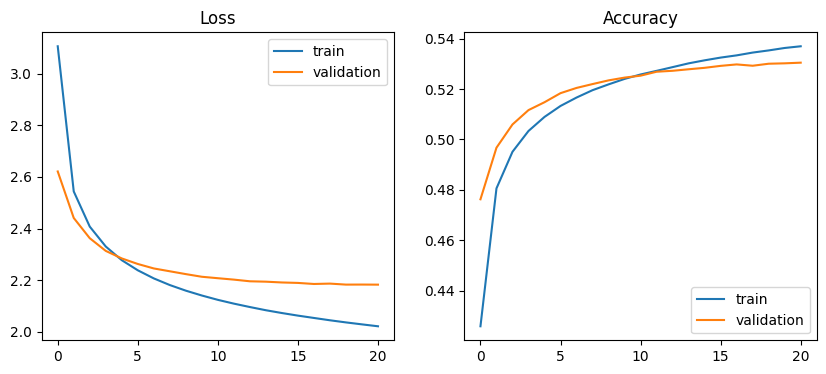

In [17]:
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_accuracy = checkpoint['train_accuracy']
val_loss = checkpoint['val_loss']
val_accuracy = checkpoint['val_accuracy']
print(f"Model was trained for {epoch + 1} epochs")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final training accuracy: {train_accuracy:.4f}")
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_accuracy:.4f}")

train_losses_history = checkpoint['train_losses']  # List of all training losses
train_accuracies_history = checkpoint['train_accuracies'] # List of training accuracies
val_losses_history = checkpoint['val_losses']      # List of all validation losses
val_accuracies_history = checkpoint['val_accuracies']  # List of validation accuracies
print(f"Training Loss history: {train_losses_history}")
print(f"Training Accuracy history: {train_accuracies_history}")
print(f"Validation Loss history: {val_losses_history}")
print(f"Validation Accuracy history: {val_accuracies_history}")

# Plot train and val loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_history, label='train')
plt.plot(val_losses_history, label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_history, label='train')
plt.plot(val_accuracies_history, label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [18]:
def evaluate_metrics(model, data_loader, max_samples=None):
    """Evaluate model using BLEU, METEOR, and CIDEr metrics"""
    model.eval()
    
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    
    refs = {}
    hypos = {}
    processed_images = set()
    
    print("Generating predictions...")
    with torch.no_grad():
        for images, captions, img_ids in tqdm.tqdm(data_loader):
            current_img_id = img_ids[0].item()
            
            if current_img_id in processed_images:
                continue
            
            if max_samples and len(processed_images) >= max_samples:
                break
                
            processed_images.add(current_img_id)
            
            images = images.to(device)
            generated_caption = model.generate_caption(
                images[0],
                tokenizer
            )
            
            ann_ids = data_loader.dataset.coco.getAnnIds(imgIds=current_img_id)
            anns = data_loader.dataset.coco.loadAnns(ann_ids)
            reference_captions = [ann['caption'] for ann in anns]
            
            img_id_str = str(current_img_id)
            refs[img_id_str] = reference_captions
            hypos[img_id_str] = [generated_caption]
    
    print(f"\nComputing scores for {len(processed_images)} unique images...")
    scores = {}
    
    for scorer, method in scorers:
        print(f'Computing {method} score...')
        score, _ = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
                
    return scores

# Evaluate model
print("Starting evaluation...")
val_scores = evaluate_metrics(model, val_loader)

# Print and save results
print("\nEvaluation Scores:")
print("=" * 50)
for metric, score in val_scores.items():
    print(f"{metric:<10}: {score:.4f}")
print("=" * 50)

Starting evaluation...
Generating predictions...


100%|██████████| 25014/25014 [04:15<00:00, 97.74it/s] 



Computing scores for 5000 unique images...
Computing ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4'] score...
{'testlen': 49260, 'reflen': 48558, 'guess': [49260, 44260, 39260, 34260], 'correct': [30765, 14121, 5841, 2501]}
ratio: 1.014456938094629
Computing METEOR score...
Computing CIDEr score...

Evaluation Scores:
Bleu_1    : 0.6245
Bleu_2    : 0.4464
Bleu_3    : 0.3095
Bleu_4    : 0.2157
METEOR    : 0.2450
CIDEr     : 0.6387


In [19]:
# Save scores
with open(os.path.join(CHECKPOINT_PATH, f'{MODEL_NAME}_evaluation_scores.json'), 'w') as f:
    json.dump(val_scores, f, indent=4)
print(f"\nScores saved to {MODEL_NAME}_evaluation_scores.json")


Scores saved to best_model.pt_evaluation_scores.json



Generating sample visualizations...
5
{'testlen': 9, 'reflen': 8, 'guess': [9, 8, 7, 6], 'correct': [8, 6, 2, 0]}
ratio: 1.1249999998593752


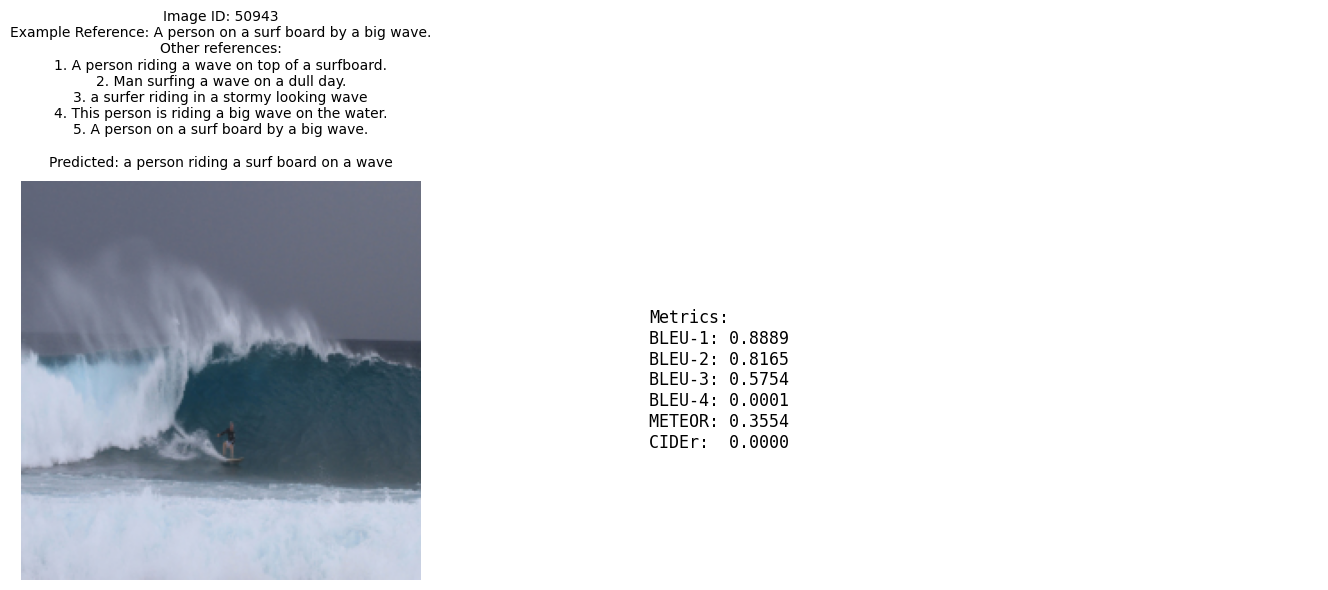

5
{'testlen': 9, 'reflen': 9, 'guess': [9, 8, 7, 6], 'correct': [5, 3, 1, 0]}
ratio: 0.9999999998888891


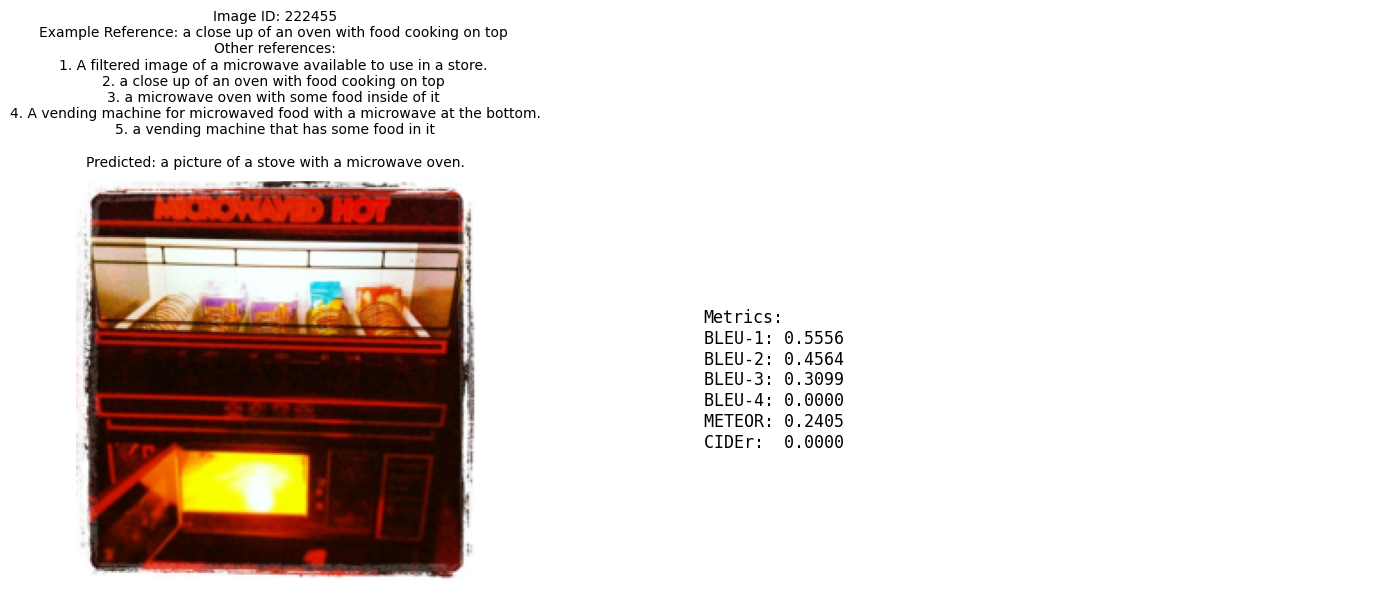

5
{'testlen': 8, 'reflen': 8, 'guess': [8, 7, 6, 5], 'correct': [5, 1, 0, 0]}
ratio: 0.9999999998750002


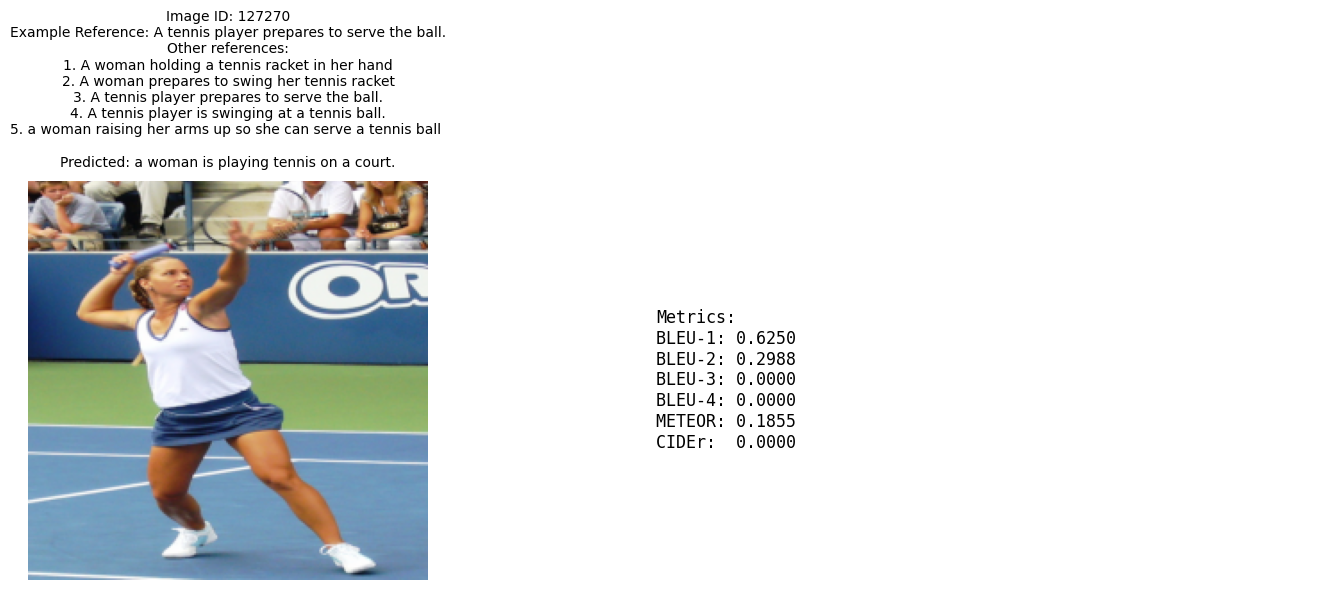

In [20]:
def denormalize_image(image):
    """Denormalize image from [-1, 1] range to [0, 1] range"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    
    img = image * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def calculate_single_caption_metrics(predicted_caption, reference_captions):
    """Calculate metrics for a single caption"""
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    
    refs = {'0': reference_captions}
    hypos = {'0': [predicted_caption]}
    
    scores = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
            
    return scores

def visualize_sample(image, actual_caption, all_captions, predicted_caption, img_id=None):
    """Visualize a single sample with metrics"""
    plt.figure(figsize=(15, 6))
    
    # Image and captions subplot
    plt.subplot(1, 2, 1)
    img_denorm = denormalize_image(image)
    plt.imshow(img_denorm.cpu().permute(1, 2, 0).numpy())
    
    # Calculate metrics
    scores = calculate_single_caption_metrics(predicted_caption, all_captions)
    
    # Create title with image ID and captions
    title = f'Image ID: {img_id.item()}\n' if img_id is not None else ''
    title += f'Example Reference: {actual_caption}\n'
    title += f'Other references:\n'
    for i, cap in enumerate(all_captions, 1):
        title += f'{i}. {cap}\n'
    title += f'\nPredicted: {predicted_caption}'
    
    plt.title(title, fontsize=10, pad=10)
    plt.axis('off')
    
    # Metrics subplot
    metrics_text = (
        f"Metrics:\n"
        f"BLEU-1: {scores['Bleu_1']:.4f}\n"
        f"BLEU-2: {scores['Bleu_2']:.4f}\n"
        f"BLEU-3: {scores['Bleu_3']:.4f}\n"
        f"BLEU-4: {scores['Bleu_4']:.4f}\n"
        f"METEOR: {scores['METEOR']:.4f}\n"
        f"CIDEr:  {scores['CIDEr']:.4f}"
    )
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, metrics_text, 
             fontsize=12, family='monospace',
             verticalalignment='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_samples(model, dataloader, num_samples=3):
    """Visualize multiple samples with their actual and predicted captions"""
    model.eval()
    
    for _ in range(num_samples):
        # Get a sample
        image, caption, img_id = next(iter(dataloader))
        image = image[0].to(device)
        
        # Get reference captions using COCO API
        reference_captions = []
        ann_ids = dataloader.dataset.coco.getAnnIds(imgIds=img_id.item())
        anns = dataloader.dataset.coco.loadAnns(ann_ids)
        print(len(anns))
        for ann in anns:
            reference_captions.append(ann['caption'])
        
        # Generate predicted caption
        predicted_caption = model.generate_caption(
            image,
            tokenizer
        )
        
        # Visualize the sample
        visualize_sample(image, caption[0], reference_captions, predicted_caption, img_id)

# Visualize some samples
print("\nGenerating sample visualizations...")
visualize_multiple_samples(model, val_loader, num_samples=3)

{'testlen': 10, 'reflen': 9, 'guess': [10, 9, 8, 7], 'correct': [6, 2, 0, 0]}
ratio: 1.1111111109876546


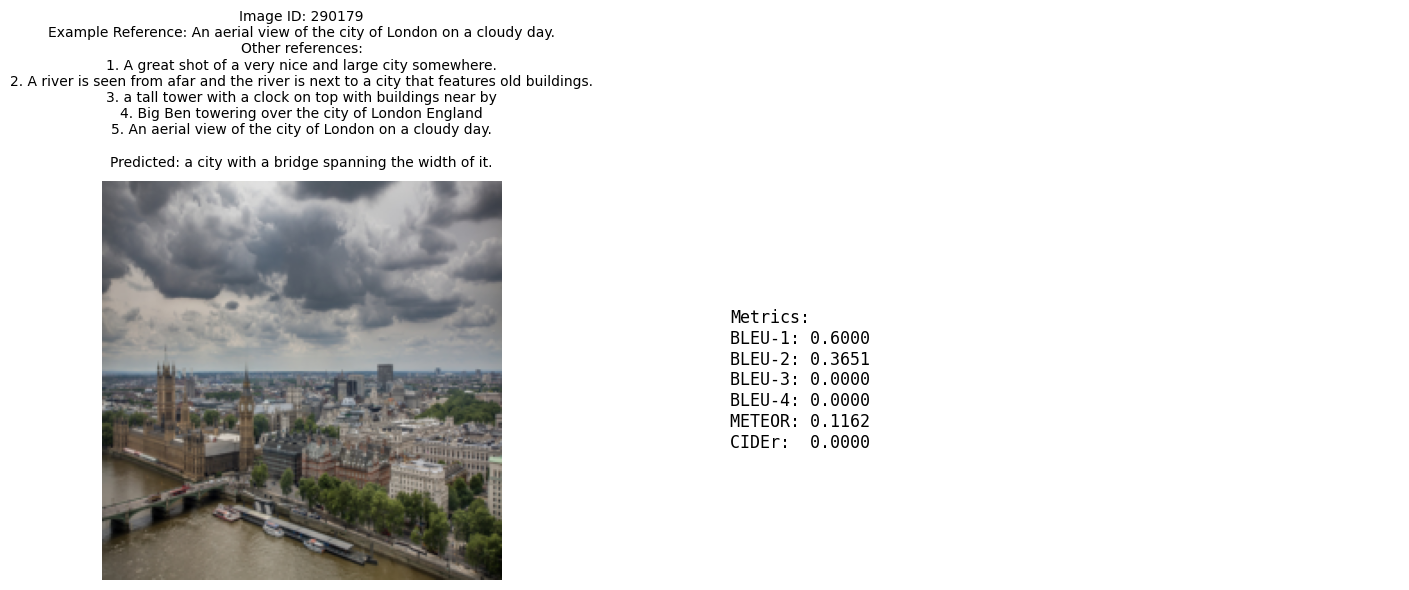

Image ID: 290179


In [ ]:
# For single image
image, caption, img_id = next(iter(val_loader))
image = image[0].to(device)

# Get actual caption (which is already a string with the BERT tokenizer version)
actual_caption = caption[0]

# Get other captions directly using COCO API
all_captions = []
ann_ids = val_dataset.coco.getAnnIds(imgIds=img_id.item())
anns = val_dataset.coco.loadAnns(ann_ids)
for ann in anns:
    all_captions.append(ann['caption'])

# Generate predicted caption using the BERT tokenizer version
predicted_caption = model.generate_caption(
    image,
    tokenizer
)

# Display the results with image ID and other actual captions
visualize_sample(image, actual_caption, all_captions, predicted_caption, img_id)
print(f"Image ID: {img_id.item()}")